In [ ]:
# Increase PARI stack size to handle large polynomial root computations
pari.allocatemem(7*10^9)  # Allocate 7GB for PARI stack


import pickle
from sage.all import sigma, nth_prime, pari
import ast
import math
import time

from scipy.signal import find_peaks, correlate
from scipy.fft import fft, fftfreq
import numpy as np


def tau(n):
    def step1(n, k):
        return 35*k^4 - 52*k^3*n + 18*k^2*n^2
    def step2(n, k):
        return sigma(k) * sigma(n - k)
    def step3(n):
        ans = 0
        for k in range(1, n):
            ans=ans+step1(n, k) * step2(n, k)
        return 24*ans
    return n^4 * sigma(n) - step3(n)

def tau_prime(k):
            pn=nth_prime(k)
            return tau(pn)

def periodic_behavior_score(main_local_minima_list, min_score=0.3, max_period=100):
    """
    Analyzes periodic behavior for all v values in main_local_minima_list.
    Uses autocorrelation and FFT to detect ANY periodic pattern (not just sine waves).
    Filters out results with weak periodicity or unreasonably large periods.
    
    Args:
        main_local_minima_list: List of tuples [(v1, points1), (v2, points2), ...]
                                where points are [(x1, y1), (x2, y2), ...]
        min_score: Minimum periodicity score to accept (default: 0.3)
        max_period: Maximum allowed period (default: 100). Results with larger periods are rejected.
    
    Returns:
        results: List of tuples [(v, score, info_dict), ...] for valid results only
    """
    
    results = []
    rejected = []
    
    print("=" * 80)
    print("PERIODIC BEHAVIOR ANALYSIS RESULTS")
    print(f"(Rejecting: score < {min_score} or period > {max_period})")
    print("=" * 80)
    
    for v, points in main_local_minima_list:
        if len(points) < 4:
            print(f"\nSkipping v = {v}: only {len(points)} points (need at least 4)")
            continue
        
        # Extract x and y coordinates, converting to plain floats
        x_data = np.array([float(p[0]) for p in points])
        y_data = np.array([float(p[1]) for p in points])
        
        # Remove mean (detrend)
        y_detrended = y_data - np.mean(y_data)
        
        # --- Method 1: Autocorrelation Analysis ---
        autocorr = correlate(y_detrended, y_detrended, mode='full')
        autocorr = autocorr[len(autocorr)//2:]
        autocorr = autocorr / autocorr[0]  # Normalize
        
        # Find peaks in autocorrelation (excluding the first peak at lag=0)
        peaks, properties = find_peaks(autocorr[1:], prominence=0.1, distance=3)
        peaks = peaks + 1  # Adjust for excluding first element
        
        # Calculate periodicity score from autocorrelation
        if len(peaks) > 0:
            autocorr_score = autocorr[peaks[0]] if peaks[0] < len(autocorr) else 0
            spacing = np.mean(np.diff(x_data))
            autocorr_period = peaks[0] * spacing
        else:
            autocorr_score = 0
            autocorr_period = None
        
        # --- Method 2: FFT Analysis ---
        n = len(y_detrended)
        yf = fft(y_detrended)
        spacing = np.mean(np.diff(x_data))
        xf = fftfreq(n, spacing)[:n//2]
        power = 2.0/n * np.abs(yf[:n//2])
        
        if len(power) > 1:
            dominant_freq_idx = np.argmax(power[1:]) + 1
            dominant_freq = xf[dominant_freq_idx]
            fft_period = 1/dominant_freq if dominant_freq > 0 else None
            
            # FFT score: ratio of dominant peak to mean power
            mean_power = np.mean(power[1:])
            fft_score = power[dominant_freq_idx] / mean_power if mean_power > 0 else 0
            fft_score = min(fft_score / 10, 1.0)  # Normalize to 0-1 range
        else:
            fft_period = None
            fft_score = 0
            dominant_freq = 0
        
        # --- Combined Score ---
        combined_score = (autocorr_score + fft_score) / 2
        
        # Determine best period estimate
        if autocorr_period and fft_period:
            # Use autocorr period if both are available and similar
            if abs(autocorr_period - fft_period) / max(autocorr_period, fft_period) < 0.3:
                best_period = autocorr_period
                period_confidence = "high"
            else:
                # Use the one with higher score
                best_period = autocorr_period if autocorr_score > fft_score else fft_period
                period_confidence = "moderate"
        elif autocorr_period:
            best_period = autocorr_period
            period_confidence = "moderate"
        elif fft_period:
            best_period = fft_period
            period_confidence = "low"
        else:
            best_period = None
            period_confidence = "none"
        
        # Check rejection criteria
        rejection_reason = None
        if combined_score < min_score:
            rejection_reason = f"score = {combined_score:.3f} (too low)"
        elif best_period and best_period > max_period:
            rejection_reason = f"period = {best_period:.2f} (too large)"
        
        if rejection_reason:
            print(f"\nREJECTED v = {v}: {rejection_reason}")
            print(f"  ({len(peaks)} autocorrelation peaks found)")
            rejected.append((v, combined_score, best_period))
            continue
        
        # Package results
        info_dict = {
            'combined_score': combined_score,
            'autocorr_score': autocorr_score,
            'autocorr_period': autocorr_period,
            'autocorr_peaks': len(peaks),
            'fft_score': fft_score,
            'fft_period': fft_period,
            'dominant_frequency': dominant_freq,
            'best_period': best_period,
            'period_confidence': period_confidence
        }
        
        results.append((v, combined_score, info_dict))
        
        print(f"\nAnalyzing v = {v}:")
        print(f"  Autocorrelation peaks found: {len(peaks)}")
        print(f"  Combined periodicity score = {combined_score:.6f}")
        print(f"  Best period estimate = {best_period:.4f} (confidence: {period_confidence})")
        print(f"  Autocorrelation: score = {autocorr_score:.4f}, period = {(autocorr_period if autocorr_period else 0):.4f}")
        print(f"  FFT: score = {fft_score:.4f}, period = {(fft_period if fft_period else 0):.4f}")
        print(f"  Dominant frequency = {dominant_freq:.6f}")
    
    print("\n" + "=" * 80)
    print(f"ANALYSIS COMPLETE: {len(results)} valid results, {len(rejected)} rejected")
    print("=" * 80)
    
    return results


    
def P_matrix(lst):
    lenlist=len(lst)
    columns=[lst]
    for k in range(1,lenlist):
        column=[0]*(k-1)
        column=column+[-k]
        column=flatten(column+[lst])
        column=column+[lst]
        column=column[:lenlist]
        columns+=[column]
    return (matrix(columns)).transpose()



def find_local_minima(data_list):
    """
    Find local minima in a list of (n, value) pairs.
    A point is a local minimum if it's smaller than both neighbors.
    """
    local_mins = []
    for i in range(1, len(data_list) - 1):
        prev_val = data_list[i-1][1]
        curr_val = data_list[i][1]
        next_val = data_list[i+1][1]
        
        if curr_val < prev_val and curr_val < next_val:
            local_mins.append(data_list[i])
    
    return local_mins

from sage.all import *
precision_bits = 100
CC = ComplexField(precision_bits)
x = polygen(QQ)  # Can remain in preamble if all polynomials are in one variable

# NEW: Compute tau_prime values ONCE before the v loop
print("Computing tau_prime values (this happens once)...")
tau_prime_list_base = []
for kk in range(1, 400):
    tau_prime_list_base.append([kk, tau_prime(kk)])
    print(("kk:",kk,time.time()))
print("tau_prime computation complete!\n")

main_matrix_list=[]
main_charpol_list=[]
main_roots_list=[]
main_mins_list=[]
main_maxes_list=[]
main_dets=[]
main_j_list=[]
main_log_mins_list=[]
main_local_minima_list=[]  # NEW: Store local minima for each c

for v in srange(0,1,1): # so v = 0
    matrix_list=[]
    charpol_list=[]
    roots_list=[]
    aar_list=[]
    centers_list=[]
    max_diameter_list=[]
    mins_list=[]
    log_mins_list=[]
    maxes_list=[]
    log_maxes_list=[]
    dets=[]
    tests=[]
    
    # NEW: Apply the v deformation to the pre-computed values
    tau_prime_list = [[k, val - v] for k, val in tau_prime_list_base]
    
    h_list=[[0,1]]+tau_prime_list  
    j_list=[(0,1)]# <<< this is deforming code, fixed c = 1.
    
    for k in range(1,350):
        print("k:",k)
        sm=0
        for r in [1..k-1]:
            sm=sm+j_list[r][1]*h_list[k-r][1]
        j_k=k*h_list[k][1]-sm
        j_list.append((k,j_k))
   
    for n in range(50,101): #this n-range is different than above
        deformed_j_list=j_list[:n]
        inputs=[pair[1] for pair in deformed_j_list]
        pl=P_matrix(inputs)
        det=pl.det()
        print((RR(v),n,time.time()))
        dets.append((n,det))
        
        cp=pl.charpoly()
        charpol_list.append((n,cp))
        roots = cp.roots(ring=CC, multiplicities=False)       
        roots_list.append((n,roots))
        pairs = [(z.real(), z.imag()) for z in roots]  
        aar = [r.abs() for r in roots]
        aar_list.append((n,aar))
    # compute absolute value for each root (before any conversion)
        if aar!=[]:
            minn = min(aar)  
            mins_list.append((n,minn))
            maxx = max(aar)  
            maxes_list.append((n,maxx))
            if minn>0:
                log_minn=log(minn)
                log_mins_list.append((n, log_minn))
            
    local_mins_mins = find_local_minima(mins_list)
    local_mins_log_mins=find_local_minima(log_mins_list)
    
    p = list_plot(mins_list, plotjoined=True, axes_labels=['', ''])
    if local_mins_mins:  # Only add red dots if there are local minima
        p += list_plot(local_mins_mins, color='red', size=10)
    print("MINIMUM MODULI")
    p.show()

    p = list_plot(log_mins_list, plotjoined=True, axes_labels=['', ''])
    if local_mins_log_mins:  # Only add red dots if there are local minima
        p += list_plot(local_mins_log_mins, color='red', size=10)
    print("LOGS MINIMUM MODULI")
    p.show()
    
    p = list_plot(maxes_list, plotjoined=True, axes_labels=['', ''])
    print("MAXIMUM MODULI")
    p.show()

    # Call with default parameters
    results = periodic_behavior_score(main_mins_list, min_score=0.3, max_period=100)

    # Or adjust the thresholds if needed:
    # results = periodic_behavior_score(main_local_minima_list, min_score=0.4, max_period=75)

In [ ]:
# Increase PARI stack size to handle large polynomial root computations
pari.allocatemem(7*10^9)  # Allocate 7GB for PARI stack


import pickle
from sage.all import sigma, nth_prime, pari
import ast
import math
import time

from scipy.signal import find_peaks, correlate
from scipy.fft import fft, fftfreq
import numpy as np


def tau(n):
    def step1(n, k):
        return 35*k^4 - 52*k^3*n + 18*k^2*n^2
    def step2(n, k):
        return sigma(k) * sigma(n - k)
    def step3(n):
        ans = 0
        for k in range(1, n):
            ans=ans+step1(n, k) * step2(n, k)
        return 24*ans
    return n^4 * sigma(n) - step3(n)

def tau_prime(k):
            pn=nth_prime(k)
            return tau(pn)

def periodic_behavior_score(main_local_minima_list, min_score=0.3, max_period=100):
    """
    Analyzes periodic behavior for all v values in main_local_minima_list.
    Uses autocorrelation and FFT to detect ANY periodic pattern (not just sine waves).
    Filters out results with weak periodicity or unreasonably large periods.
    
    Args:
        main_local_minima_list: List of tuples [(v1, points1), (v2, points2), ...]
                                where points are [(x1, y1), (x2, y2), ...]
        min_score: Minimum periodicity score to accept (default: 0.3)
        max_period: Maximum allowed period (default: 100). Results with larger periods are rejected.
    
    Returns:
        results: List of tuples [(v, score, info_dict), ...] for valid results only
    """
    
    results = []
    rejected = []
    
    print("=" * 80)
    print("PERIODIC BEHAVIOR ANALYSIS RESULTS")
    print(f"(Rejecting: score < {min_score} or period > {max_period})")
    print("=" * 80)
    
    for v, points in main_local_minima_list:
        if len(points) < 4:
            print(f"\nSkipping v = {v}: only {len(points)} points (need at least 4)")
            continue
        
        # Extract x and y coordinates, converting to plain floats
        x_data = np.array([float(p[0]) for p in points])
        y_data = np.array([float(p[1]) for p in points])
        
        # Remove mean (detrend)
        y_detrended = y_data - np.mean(y_data)
        
        # --- Method 1: Autocorrelation Analysis ---
        autocorr = correlate(y_detrended, y_detrended, mode='full')
        autocorr = autocorr[len(autocorr)//2:]
        autocorr = autocorr / autocorr[0]  # Normalize
        
        # Find peaks in autocorrelation (excluding the first peak at lag=0)
        peaks, properties = find_peaks(autocorr[1:], prominence=0.1, distance=3)
        peaks = peaks + 1  # Adjust for excluding first element
        
        # Calculate periodicity score from autocorrelation
        if len(peaks) > 0:
            autocorr_score = autocorr[peaks[0]] if peaks[0] < len(autocorr) else 0
            spacing = np.mean(np.diff(x_data))
            autocorr_period = peaks[0] * spacing
        else:
            autocorr_score = 0
            autocorr_period = None
        
        # --- Method 2: FFT Analysis ---
        n = len(y_detrended)
        yf = fft(y_detrended)
        spacing = np.mean(np.diff(x_data))
        xf = fftfreq(n, spacing)[:n//2]
        power = 2.0/n * np.abs(yf[:n//2])
        
        if len(power) > 1:
            dominant_freq_idx = np.argmax(power[1:]) + 1
            dominant_freq = xf[dominant_freq_idx]
            fft_period = 1/dominant_freq if dominant_freq > 0 else None
            
            # FFT score: ratio of dominant peak to mean power
            mean_power = np.mean(power[1:])
            fft_score = power[dominant_freq_idx] / mean_power if mean_power > 0 else 0
            fft_score = min(fft_score / 10, 1.0)  # Normalize to 0-1 range
        else:
            fft_period = None
            fft_score = 0
            dominant_freq = 0
        
        # --- Combined Score ---
        combined_score = (autocorr_score + fft_score) / 2
        
        # Determine best period estimate
        if autocorr_period and fft_period:
            # Use autocorr period if both are available and similar
            if abs(autocorr_period - fft_period) / max(autocorr_period, fft_period) < 0.3:
                best_period = autocorr_period
                period_confidence = "high"
            else:
                # Use the one with higher score
                best_period = autocorr_period if autocorr_score > fft_score else fft_period
                period_confidence = "moderate"
        elif autocorr_period:
            best_period = autocorr_period
            period_confidence = "moderate"
        elif fft_period:
            best_period = fft_period
            period_confidence = "low"
        else:
            best_period = None
            period_confidence = "none"
        
        # Check rejection criteria
        rejection_reason = None
        if combined_score < min_score:
            rejection_reason = f"score = {combined_score:.3f} (too low)"
        elif best_period and best_period > max_period:
            rejection_reason = f"period = {best_period:.2f} (too large)"
        
        if rejection_reason:
            print(f"\nREJECTED v = {v}: {rejection_reason}")
            print(f"  ({len(peaks)} autocorrelation peaks found)")
            rejected.append((v, combined_score, best_period))
            continue
        
        # Package results
        info_dict = {
            'combined_score': combined_score,
            'autocorr_score': autocorr_score,
            'autocorr_period': autocorr_period,
            'autocorr_peaks': len(peaks),
            'fft_score': fft_score,
            'fft_period': fft_period,
            'dominant_frequency': dominant_freq,
            'best_period': best_period,
            'period_confidence': period_confidence
        }
        
        results.append((v, combined_score, info_dict))
        
        print(f"\nAnalyzing v = {v}:")
        print(f"  Autocorrelation peaks found: {len(peaks)}")
        print(f"  Combined periodicity score = {combined_score:.6f}")
        print(f"  Best period estimate = {best_period:.4f} (confidence: {period_confidence})")
        print(f"  Autocorrelation: score = {autocorr_score:.4f}, period = {(autocorr_period if autocorr_period else 0):.4f}")
        print(f"  FFT: score = {fft_score:.4f}, period = {(fft_period if fft_period else 0):.4f}")
        print(f"  Dominant frequency = {dominant_freq:.6f}")
    
    print("\n" + "=" * 80)
    print(f"ANALYSIS COMPLETE: {len(results)} valid results, {len(rejected)} rejected")
    print("=" * 80)
    
    return results


    
def P_matrix(lst):
    lenlist=len(lst)
    columns=[lst]
    for k in range(1,lenlist):
        column=[0]*(k-1)
        column=column+[-k]
        column=flatten(column+[lst])
        column=column+[lst]
        column=column[:lenlist]
        columns+=[column]
    return (matrix(columns)).transpose()



def find_local_minima(data_list):
    """
    Find local minima in a list of (n, value) pairs.
    A point is a local minimum if it's smaller than both neighbors.
    """
    local_mins = []
    for i in range(1, len(data_list) - 1):
        prev_val = data_list[i-1][1]
        curr_val = data_list[i][1]
        next_val = data_list[i+1][1]
        
        if curr_val < prev_val and curr_val < next_val:
            local_mins.append(data_list[i])
    
    return local_mins

from sage.all import *
precision_bits = 100
CC = ComplexField(precision_bits)
x = polygen(QQ)  # Can remain in preamble if all polynomials are in one variable

# NEW: Compute tau_prime values ONCE before the v loop
print("Computing tau_prime values (this happens once)...")
tau_prime_list_base = []
for kk in range(1, 400):
    tau_prime_list_base.append([kk, tau_prime(kk)])
    print(("kk:",kk,time.time()))
print("tau_prime computation complete!\n")

main_matrix_list=[]
main_charpol_list=[]
main_roots_list=[]
main_mins_list=[]
main_maxes_list=[]
main_dets=[]
main_j_list=[]
main_log_mins_list=[]
main_local_minima_list=[]  # NEW: Store local minima for each c

for v in srange(0,1,1): # so v = 0
    matrix_list=[]
    charpol_list=[]
    roots_list=[]
    aar_list=[]
    centers_list=[]
    max_diameter_list=[]
    mins_list=[]
    log_mins_list=[]
    maxes_list=[]
    log_maxes_list=[]
    dets=[]
    tests=[]
    
    # NEW: Apply the v deformation to the pre-computed values
    tau_prime_list = [[k, val - v] for k, val in tau_prime_list_base]
    
    h_list=[[0,1]]+tau_prime_list  
    j_list=[(0,1)]# <<< this is deforming code, fixed c = 1.
    # In "deformations for sinusoidality 5oct25no1", I said 'j_list=[1,1] and 
    # got different plots (for log minima, anyway) (I was listing only the values not the indices there)
    
    for k in range(1,350):
        print("k:",k)
        sm=0
        for r in [1..k-1]:
            sm=sm+j_list[r][1]*h_list[k-r][1]
        j_k=k*h_list[k][1]-sm
        j_list.append((k,j_k))
   
    for n in range(50,201): #this n-range is different than above
        deformed_j_list=j_list[:n]
        inputs=[pair[1] for pair in deformed_j_list]
        pl=P_matrix(inputs)
        det=pl.det()
        print((RR(v),n,time.time()))
        dets.append((n,det))
        
        cp=pl.charpoly()
        charpol_list.append((n,cp))
        roots = cp.roots(ring=CC, multiplicities=False)       
        roots_list.append((n,roots))
        pairs = [(z.real(), z.imag()) for z in roots]  
        aar = [r.abs() for r in roots]
        aar_list.append((n,aar))
    # compute absolute value for each root (before any conversion)
        if aar!=[]:
            minn = min(aar)  
            mins_list.append((n,minn))
            maxx = max(aar)  
            maxes_list.append((n,maxx))
            if minn>0:
                log_minn=log(minn)
                log_mins_list.append((n,log_minn))
            
    local_mins_mins = find_local_minima(mins_list)
    local_mins_log_mins=find_local_minima(log_mins_list)
    
    p = list_plot(mins_list, plotjoined=True, axes_labels=['', ''])
    if local_mins_mins:  # Only add red dots if there are local minima
        p += list_plot(local_mins_mins, color='red', size=10)
    print("MINIMUM MODULI")
    p.show()

    p = list_plot(log_mins_list, plotjoined=True, axes_labels=['', ''])
    if local_mins_log_mins:  # Only add red dots if there are local minima
        p += list_plot(local_mins_log_mins, color='red', size=10)
    print("LOGS MINIMUM MODULI")
    p.show()
    
    p = list_plot(maxes_list, plotjoined=True, axes_labels=['', ''])
    print("MAXIMUM MODULI")
    p.show()

    # Call with default parameters
    results = periodic_behavior_score(main_mins_list, min_score=0.3, max_period=100)

    # Or adjust the thresholds if needed:
    # results = periodic_behavior_score(main_local_minima_list, min_score=0.4, max_period=75)

with open('/Users/barrybrent/data/run17oct25no1.txt', 'wb') as wfile:
    pickle.dump(roots_list, wfile)
with open('/Users/barrybrent/data/run17oct25no2.txt', 'wb') as wfile:
    pickle.dump(charpol_list, wfile)
with open('/Users/barrybrent/data/run17oct25no3.txt', 'wb') as wfile:
    pickle.dump(mins_list, wfile)
with open('/Users/barrybrent/data/run17oct25no4.txt', 'wb') as wfile:
    pickle.dump(dets, wfile)
with open('/Users/barrybrent/data/run17oct25no5.txt', 'wb') as wfile:
    pickle.dump(maxes_list, wfile)
with open('/Users/barrybrent/data/run17oct25no6.txt', 'wb') as wfile:
    pickle.dump(j_list, wfile)
# NEW: Save the local minima
with open('/Users/barrybrent/data/run17oct25no7.txt', 'wb') as wfile:
    pickle.dump(local_mins_log_mins, wfile)

PARI stack size set to 7000000000 bytes, maximum size set to 7000002560
Computing tau_prime values (this happens once)...
('kk:', 1, 1760802144.62257)
('kk:', 2, 1760802144.622704)
('kk:', 3, 1760802144.6228192)
('kk:', 4, 1760802144.622965)
('kk:', 5, 1760802144.623172)
('kk:', 6, 1760802144.623413)
('kk:', 7, 1760802144.623717)
('kk:', 8, 1760802144.624052)
('kk:', 9, 1760802144.6244538)
('kk:', 10, 1760802144.624956)
('kk:', 11, 1760802144.625493)
('kk:', 12, 1760802144.626133)
('kk:', 13, 1760802144.6268501)
('kk:', 14, 1760802144.627593)
('kk:', 15, 1760802144.628407)
('kk:', 16, 1760802144.6293771)
('kk:', 17, 1760802144.630403)
('kk:', 18, 1760802144.631449)
('kk:', 19, 1760802144.6326)
('kk:', 20, 1760802144.6338181)
('kk:', 21, 1760802144.635066)
('kk:', 22, 1760802144.636416)
('kk:', 23, 1760802144.637855)
('kk:', 24, 1760802144.639385)
('kk:', 25, 1760802144.6410701)
('kk:', 26, 1760802144.642814)
('kk:', 27, 1760802144.644578)
('kk:', 28, 1760802144.6464288)
('kk:', 29, 176

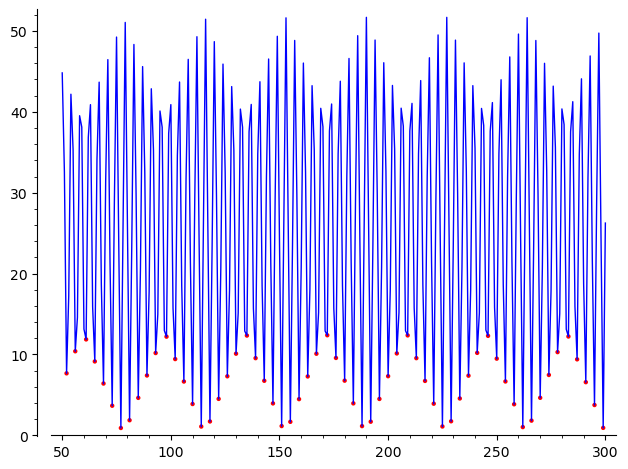

LOGS MINIMUM MODULI


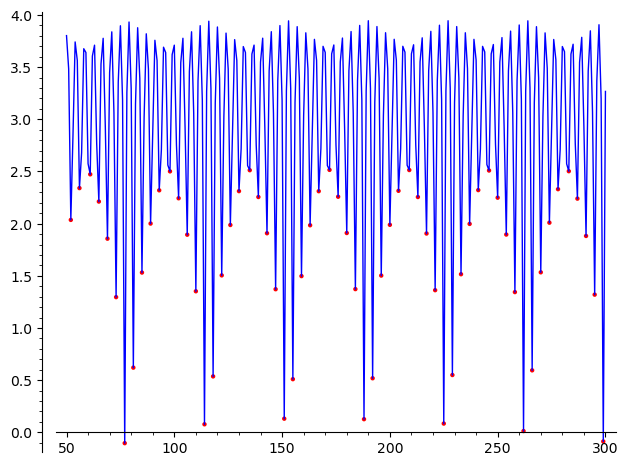

MAXIMUM MODULI


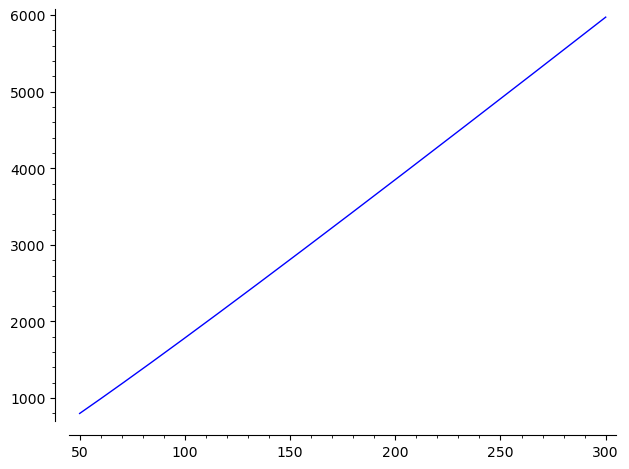

PERIODIC BEHAVIOR ANALYSIS RESULTS
(Rejecting: score < 0.300000000000000 or period > 100)

ANALYSIS COMPLETE: 0 valid results, 0 rejected


In [1]:
# Increase PARI stack size to handle large polynomial root computations
pari.allocatemem(7*10^9)  # Allocate 7GB for PARI stack


import pickle
from sage.all import sigma, nth_prime, pari
import ast
import math
import time

from scipy.signal import find_peaks, correlate
from scipy.fft import fft, fftfreq
import numpy as np


def tau(n):
    def step1(n, k):
        return 35*k^4 - 52*k^3*n + 18*k^2*n^2
    def step2(n, k):
        return sigma(k) * sigma(n - k)
    def step3(n):
        ans = 0
        for k in range(1, n):
            ans=ans+step1(n, k) * step2(n, k)
        return 24*ans
    return n^4 * sigma(n) - step3(n)

def tau_prime(k):
            pn=nth_prime(k)
            return tau(pn)

def periodic_behavior_score(main_local_minima_list, min_score=0.3, max_period=100):
    """
    Analyzes periodic behavior for all v values in main_local_minima_list.
    Uses autocorrelation and FFT to detect ANY periodic pattern (not just sine waves).
    Filters out results with weak periodicity or unreasonably large periods.
    
    Args:
        main_local_minima_list: List of tuples [(v1, points1), (v2, points2), ...]
                                where points are [(x1, y1), (x2, y2), ...]
        min_score: Minimum periodicity score to accept (default: 0.3)
        max_period: Maximum allowed period (default: 100). Results with larger periods are rejected.
    
    Returns:
        results: List of tuples [(v, score, info_dict), ...] for valid results only
    """
    
    results = []
    rejected = []
    
    print("=" * 80)
    print("PERIODIC BEHAVIOR ANALYSIS RESULTS")
    print(f"(Rejecting: score < {min_score} or period > {max_period})")
    print("=" * 80)
    
    for v, points in main_local_minima_list:
        if len(points) < 4:
            print(f"\nSkipping v = {v}: only {len(points)} points (need at least 4)")
            continue
        
        # Extract x and y coordinates, converting to plain floats
        x_data = np.array([float(p[0]) for p in points])
        y_data = np.array([float(p[1]) for p in points])
        
        # Remove mean (detrend)
        y_detrended = y_data - np.mean(y_data)
        
        # --- Method 1: Autocorrelation Analysis ---
        autocorr = correlate(y_detrended, y_detrended, mode='full')
        autocorr = autocorr[len(autocorr)//2:]
        autocorr = autocorr / autocorr[0]  # Normalize
        
        # Find peaks in autocorrelation (excluding the first peak at lag=0)
        peaks, properties = find_peaks(autocorr[1:], prominence=0.1, distance=3)
        peaks = peaks + 1  # Adjust for excluding first element
        
        # Calculate periodicity score from autocorrelation
        if len(peaks) > 0:
            autocorr_score = autocorr[peaks[0]] if peaks[0] < len(autocorr) else 0
            spacing = np.mean(np.diff(x_data))
            autocorr_period = peaks[0] * spacing
        else:
            autocorr_score = 0
            autocorr_period = None
        
        # --- Method 2: FFT Analysis ---
        n = len(y_detrended)
        yf = fft(y_detrended)
        spacing = np.mean(np.diff(x_data))
        xf = fftfreq(n, spacing)[:n//2]
        power = 2.0/n * np.abs(yf[:n//2])
        
        if len(power) > 1:
            dominant_freq_idx = np.argmax(power[1:]) + 1
            dominant_freq = xf[dominant_freq_idx]
            fft_period = 1/dominant_freq if dominant_freq > 0 else None
            
            # FFT score: ratio of dominant peak to mean power
            mean_power = np.mean(power[1:])
            fft_score = power[dominant_freq_idx] / mean_power if mean_power > 0 else 0
            fft_score = min(fft_score / 10, 1.0)  # Normalize to 0-1 range
        else:
            fft_period = None
            fft_score = 0
            dominant_freq = 0
        
        # --- Combined Score ---
        combined_score = (autocorr_score + fft_score) / 2
        
        # Determine best period estimate
        if autocorr_period and fft_period:
            # Use autocorr period if both are available and similar
            if abs(autocorr_period - fft_period) / max(autocorr_period, fft_period) < 0.3:
                best_period = autocorr_period
                period_confidence = "high"
            else:
                # Use the one with higher score
                best_period = autocorr_period if autocorr_score > fft_score else fft_period
                period_confidence = "moderate"
        elif autocorr_period:
            best_period = autocorr_period
            period_confidence = "moderate"
        elif fft_period:
            best_period = fft_period
            period_confidence = "low"
        else:
            best_period = None
            period_confidence = "none"
        
        # Check rejection criteria
        rejection_reason = None
        if combined_score < min_score:
            rejection_reason = f"score = {combined_score:.3f} (too low)"
        elif best_period and best_period > max_period:
            rejection_reason = f"period = {best_period:.2f} (too large)"
        
        if rejection_reason:
            print(f"\nREJECTED v = {v}: {rejection_reason}")
            print(f"  ({len(peaks)} autocorrelation peaks found)")
            rejected.append((v, combined_score, best_period))
            continue
        
        # Package results
        info_dict = {
            'combined_score': combined_score,
            'autocorr_score': autocorr_score,
            'autocorr_period': autocorr_period,
            'autocorr_peaks': len(peaks),
            'fft_score': fft_score,
            'fft_period': fft_period,
            'dominant_frequency': dominant_freq,
            'best_period': best_period,
            'period_confidence': period_confidence
        }
        
        results.append((v, combined_score, info_dict))
        
        print(f"\nAnalyzing v = {v}:")
        print(f"  Autocorrelation peaks found: {len(peaks)}")
        print(f"  Combined periodicity score = {combined_score:.6f}")
        print(f"  Best period estimate = {best_period:.4f} (confidence: {period_confidence})")
        print(f"  Autocorrelation: score = {autocorr_score:.4f}, period = {(autocorr_period if autocorr_period else 0):.4f}")
        print(f"  FFT: score = {fft_score:.4f}, period = {(fft_period if fft_period else 0):.4f}")
        print(f"  Dominant frequency = {dominant_freq:.6f}")
    
    print("\n" + "=" * 80)
    print(f"ANALYSIS COMPLETE: {len(results)} valid results, {len(rejected)} rejected")
    print("=" * 80)
    
    return results


    
def P_matrix(lst):
    lenlist=len(lst)
    columns=[lst]
    for k in range(1,lenlist):
        column=[0]*(k-1)
        column=column+[-k]
        column=flatten(column+[lst])
        column=column+[lst]
        column=column[:lenlist]
        columns+=[column]
    return (matrix(columns)).transpose()



def find_local_minima(data_list):
    """
    Find local minima in a list of (n, value) pairs.
    A point is a local minimum if it's smaller than both neighbors.
    """
    local_mins = []
    for i in range(1, len(data_list) - 1):
        prev_val = data_list[i-1][1]
        curr_val = data_list[i][1]
        next_val = data_list[i+1][1]
        
        if curr_val < prev_val and curr_val < next_val:
            local_mins.append(data_list[i])
    
    return local_mins

from sage.all import *
precision_bits = 100
CC = ComplexField(precision_bits)
x = polygen(QQ)  # Can remain in preamble if all polynomials are in one variable

# NEW: Compute tau_prime values ONCE before the v loop
print("Computing tau_prime values (this happens once)...")
tau_prime_list_base = []
for kk in range(1, 400):
    tau_prime_list_base.append([kk, tau_prime(kk)])
    print(("kk:",kk,time.time()))
print("tau_prime computation complete!\n")

main_matrix_list=[]
main_charpol_list=[]
main_roots_list=[]
main_mins_list=[]
main_maxes_list=[]
main_dets=[]
main_j_list=[]
main_log_mins_list=[]
main_local_minima_list=[]  # NEW: Store local minima for each c

for v in srange(0,1,1): # so v = 0
    matrix_list=[]
    charpol_list=[]
    roots_list=[]
    aar_list=[]
    centers_list=[]
    max_diameter_list=[]
    mins_list=[]
    log_mins_list=[]
    maxes_list=[]
    log_maxes_list=[]
    dets=[]
    tests=[]
    
    # NEW: Apply the v deformation to the pre-computed values
    tau_prime_list = [[k, val - v] for k, val in tau_prime_list_base]
    
    h_list=[[0,1]]+tau_prime_list  
    j_list=[(0,1)]# <<< this is deforming code, fixed c = 1.
    
    for k in range(1,350):
        print("k:",k)
        sm=0
        for r in [1..k-1]:
            sm=sm+j_list[r][1]*h_list[k-r][1]
        j_k=k*h_list[k][1]-sm
        j_list.append((k,j_k))
   
    for n in range(50,301): 
        deformed_j_list=j_list[:n]
        inputs=[pair[1] for pair in deformed_j_list]
        pl=P_matrix(inputs)
        det=pl.det()
        print((RR(v),n,time.time()))
        dets.append((n,det))
        
        cp=pl.charpoly()
        charpol_list.append((n,cp))
        roots = cp.roots(ring=CC, multiplicities=False)       
        roots_list.append((n,roots))
        pairs = [(z.real(), z.imag()) for z in roots]  
        aar = [r.abs() for r in roots]
        aar_list.append((n,aar))
    # compute absolute value for each root (before any conversion)
        if aar!=[]:
            minn = min(aar)  
            mins_list.append((n,minn))
            maxx = max(aar)  
            maxes_list.append((n,maxx))
            if minn>0:
                log_minn=log(minn)
                log_mins_list.append((n,log_minn))
            
    local_mins_mins = find_local_minima(mins_list)
    local_mins_log_mins=find_local_minima(log_mins_list)
    
    p = list_plot(mins_list, plotjoined=True, axes_labels=['', ''])
    if local_mins_mins:  # Only add red dots if there are local minima
        p += list_plot(local_mins_mins, color='red', size=10)
    print("MINIMUM MODULI")
    p.show()

    p = list_plot(log_mins_list, plotjoined=True, axes_labels=['', ''])
    if local_mins_log_mins:  # Only add red dots if there are local minima
        p += list_plot(local_mins_log_mins, color='red', size=10)
    print("LOGS MINIMUM MODULI")
    p.show()
    
    p = list_plot(maxes_list, plotjoined=True, axes_labels=['', ''])
    print("MAXIMUM MODULI")
    p.show()

    # Call with default parameters
    results = periodic_behavior_score(main_mins_list, min_score=0.3, max_period=100)

    # Or adjust the thresholds if needed:
    # results = periodic_behavior_score(main_local_minima_list, min_score=0.4, max_period=75)

with open('/Users/barrybrent/data/run17oct25no108.txt', 'wb') as wfile:
    pickle.dump(roots_list, wfile)
with open('/Users/barrybrent/data/run17oct25no109.txt', 'wb') as wfile:
    pickle.dump(charpol_list, wfile)
with open('/Users/barrybrent/data/run17oct25no110.txt', 'wb') as wfile:
    pickle.dump(mins_list, wfile)
with open('/Users/barrybrent/data/run17oct25no111.txt', 'wb') as wfile:
    pickle.dump(dets, wfile)
with open('/Users/barrybrent/data/run17oct25no112.txt', 'wb') as wfile:
    pickle.dump(maxes_list, wfile)
with open('/Users/barrybrent/data/run17oct25no113.txt', 'wb') as wfile:
    pickle.dump(j_list, wfile)
# NEW: Save the local minima
with open('/Users/barrybrent/data/run17oct25no114.txt', 'wb') as wfile:
    pickle.dump(local_mins_log_mins, wfile)

In [2]:
# the scoring stats above were due to a coding error.
#Here I do the tests.
# Test mins_list
results_mins = periodic_behavior_score([(0, mins_list)], min_score=0.3, max_period=100)

# Test local_mins_log_mins  
results_log_mins = periodic_behavior_score([(0, local_mins_log_mins)], min_score=0.3, max_period=100)

PERIODIC BEHAVIOR ANALYSIS RESULTS
(Rejecting: score < 0.300000000000000 or period > 100)

Analyzing v = 0:
  Autocorrelation peaks found: 56
  Combined periodicity score = 0.982629
  Best period estimate = 4.0000 (confidence: high)
  Autocorrelation: score = 0.9653, period = 4.0000
  FFT: score = 1.0000, period = 4.1148
  Dominant frequency = 0.243028

ANALYSIS COMPLETE: 1 valid results, 0 rejected
PERIODIC BEHAVIOR ANALYSIS RESULTS
(Rejecting: score < 0.300000000000000 or period > 100)

Analyzing v = 0:
  Autocorrelation peaks found: 6
  Combined periodicity score = 0.823358
  Best period estimate = 37.0500 (confidence: high)
  Autocorrelation: score = 0.8440, period = 37.0500
  FFT: score = 0.8027, period = 35.8738
  Dominant frequency = 0.027875

ANALYSIS COMPLETE: 1 valid results, 0 rejected


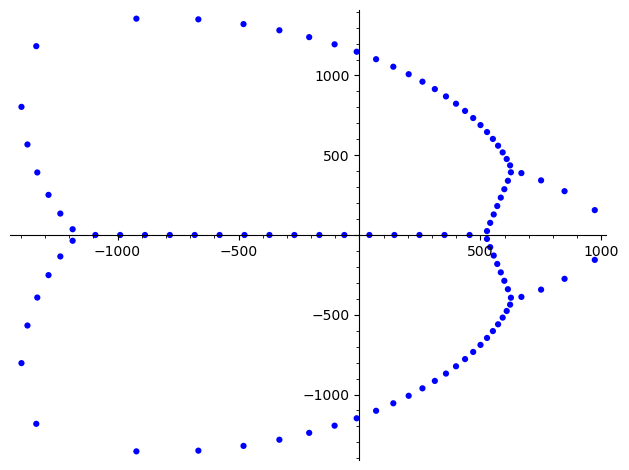

In [3]:
# Plot roots for n=100
n_value = 100
for n, roots in roots_list:
    if n == n_value:
        points = [(z.real(), z.imag()) for z in roots]
        p = list_plot(points, size=20)
        p.show()
        break

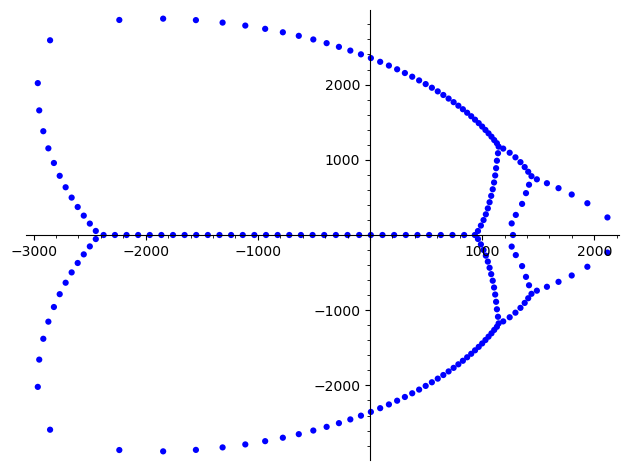

In [4]:
# Plot roots for n=200
n_value = 200
for n, roots in roots_list:
    if n == n_value:
        points = [(z.real(), z.imag()) for z in roots]
        p = list_plot(points, size=20)
        p.show()
        break

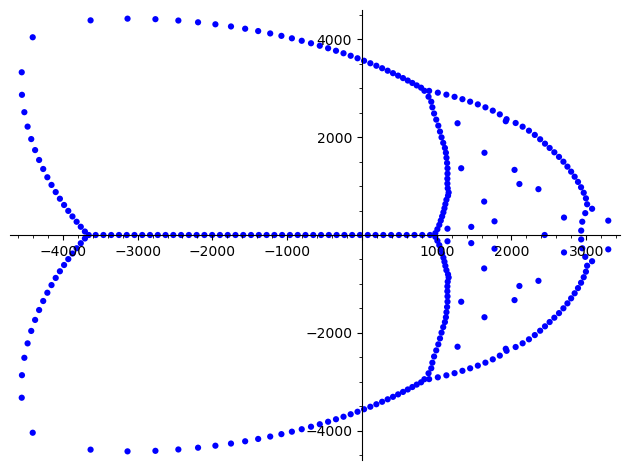

In [5]:
# Plot roots for n=300
n_value = 300
for n, roots in roots_list:
    if n == n_value:
        points = [(z.real(), z.imag()) for z in roots]
        p = list_plot(points, size=20)
        p.show()
        break

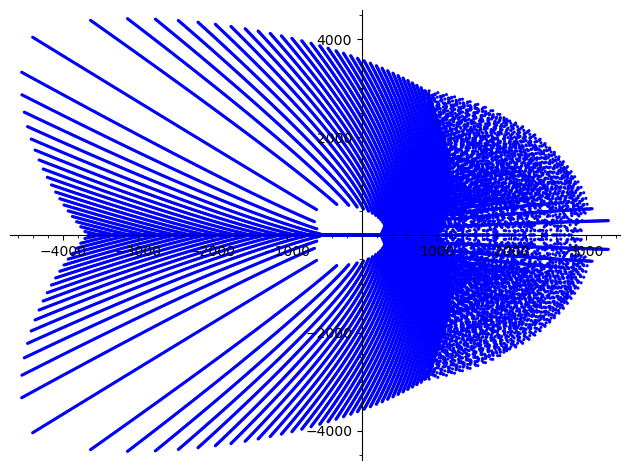

In [6]:
all_points = []
for n, roots in roots_list:
    for z in roots:
        all_points.append((z.real(), z.imag()))
        
p = list_plot(all_points, size=5)
p.show()

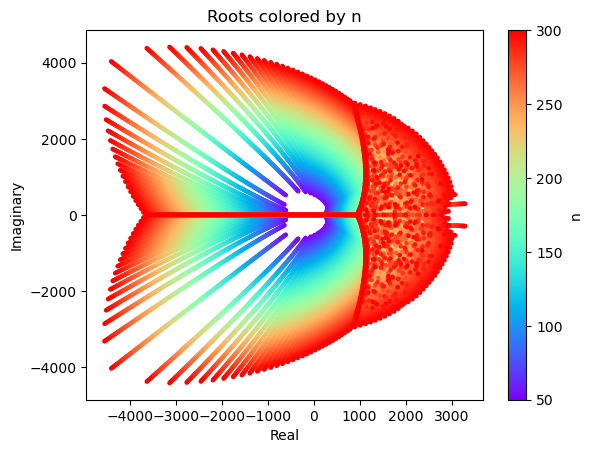

In [7]:
from sage.plot.colors import rainbow
import matplotlib.pyplot as plt

n_values = [n for n, roots in roots_list]
n_min, n_max = min(n_values), max(n_values)
colors = rainbow(len(n_values))

# Collect all points with their n values for matplotlib
all_points = []
all_n_values = []
for n, roots in roots_list:
    for z in roots:
        all_points.append((float(z.real()), float(z.imag())))
        all_n_values.append(n)

# Use matplotlib for better color mapping
real_parts = [p[0] for p in all_points]
imag_parts = [p[1] for p in all_points]

plt.scatter(real_parts, imag_parts, c=all_n_values, cmap='rainbow', s=5)
plt.colorbar(label='n')
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.title('Roots colored by n')
plt.show()